# Lab 2 - Fully Connected Feedforward Network with MNIST
# Model Overview

In this lab, we will train a fully connected feedforward network on MNIST data. 

The lab comprises two parts. During the first part, the instructor will walk you through the code to define, train, and evaluate the initial version of FCNN model. In the second part you will compete with other students to improve the performance of the model.


Our fully connected feedforward network - a.k.a multi-layer perceptron - will be relatively simple with 2 hidden layers (`num_hidden_layers`). The number of nodes in the hidden layer being a parameter specified by `hidden_layers_dim`. The figure below illustrates the entire model we will use in this tutorial in the context of MNIST data.

![model-mlp](http://cntk.ai/jup/cntk103c_MNIST_MLP.png)

In this and the following labs we will demonstrate the use of the Functional API. 

# Code Walkthrough
## Initialize environment

In [1]:
import sys
import os
import time
import numpy as np
import cntk as C
from IPython.display import Image

# Ensure we always get the same amount of randomness
np.random.seed(0)


## Data reading

In this lab we are using the MNIST data pre-processed to follow CNTK CTF format. 


    |labels 0 0 0 0 0 0 0 1 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
                                                 

Each line in the file contains two key-value pairs, also refered as streams. The `labels` stream is the one-hot encoded representation of a digit 0-9. The `features` stream is a 784 vector of 0-255 integers representing 28 x 28 pixel grayscale image.

Our dataset includes three files: the training file with 50,000 images, the validation file with 10,000 images, and the testing file with 10,000 images.

To read/sample the files, we define a `create_reader` function that configures and returns the CNTK MinibatchSource object.
    

In [2]:
training_file = "../Data/MNIST/MNIST_train.txt"
validation_file = "../Data/MNIST/MNIST_validate.txt"
test_file = '../Data/MNIST/MNIST_test.txt'

# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=num_label_classes),
        features   = C.io.StreamDef(field='features', shape=input_dim)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

## Network definition and training

### Define the network


In [3]:
# Define a fully connected feedforward classification network factory with sigmoid neurons in the hidden layers
def create_fcnn_network(input_dim, num_hidden_layers, hidden_layer_dim, num_output_classes):
    # Create inputs 
    features = C.input_variable(input_dim)

    # Scale the input features
    feature_scale = 1.0/256.0
    features_norm = C.element_times(feature_scale, features) 
    
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.sigmoid):
        network_template = C.layers.Sequential([
            C.layers.For(range(num_hidden_layers), lambda i: C.layers.Dense(hidden_layer_dim, name = 'hidden' + str(i))),
            C.layers.Dense(num_output_classes, activation = None, name='classify')])
    
    z = network_template(features_norm)
    return z
    


### Create and visualize the network

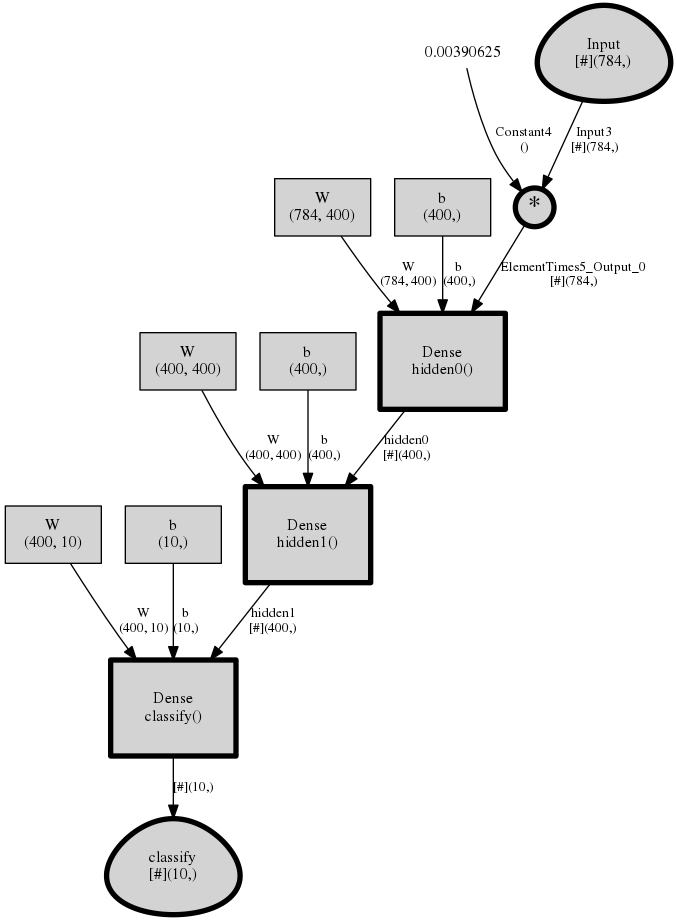

In [4]:
input_dim = 784
num_output_classes = 10
num_hidden_layers = 2
hidden_layer_dim = 400

z = create_fcnn_network(input_dim, num_hidden_layers, hidden_layer_dim, num_output_classes)
C.logging.graph.plot(z, "graph.png")
Image("graph.png")

### Configure training 
#### Configure a trainer

In [5]:
def create_trainer(network, labels):
    ## Define loss and metric
    loss = C.cross_entropy_with_softmax(network, labels)
    metric = C.classification_error(network, labels)

    # Create an SGD learner
    lr_schedule = C.learning_rate_schedule(0.2, C.UnitType.minibatch)
    learner = C.sgd(network.parameters, lr_schedule)

    # Create a progress printing helper
    progress_printer = C.logging.ProgressPrinter()

    # Create a trainer
    return C.Trainer(network, (loss, metric), [learner], [progress_printer])


#### Configure a training session

In [6]:
def train_and_validate(network, training_file, validation_file, mb_schedule, epoch_size, num_epochs):

    # Extract input and output dimensions
    input_dim = network.arguments[0].shape[0]
    num_output_classes = network.outputs[0].shape[0]
    
    # Create the training and validation data set readers
    reader_train = create_reader(training_file, True, input_dim, num_output_classes)
    reader_validate = create_reader(validation_file, False, input_dim, num_output_classes)

     # Define mappings from reader streams to network and ground truth inputs
    features = network.arguments[0]
    labels = C.input_variable(num_output_classes, is_sparse=True)
   
    input_map_training = {
        features: reader_train.streams.features,
        labels: reader_train.streams.labels
    }

    # Define mappings from reader streams to network inputs
    input_map_validation = {
        features: reader_validate.streams.features,
        labels: reader_validate.streams.labels
    }
    
    # Create a trainer
    trainer = create_trainer(network, labels)

    # Set up cross-validation configuration
    cv_config = C.CrossValidationConfig(minibatch_source=reader_validate,
                                        model_inputs_to_streams = input_map_validation,
                                        frequency=None)

    # Create a training session
    training_sess = C.training_session(trainer=trainer,
                                 mb_source=reader_train,
                                 mb_size=mb_schedule,
                                 model_inputs_to_streams=input_map_training,
                                 progress_frequency=epoch_size,
                                 max_samples=epoch_size * num_epochs,
                                 cv_config=cv_config 
                                )

    training_sess.train()

### Execute training

In [7]:

epoch_size = 6400
num_epochs = 100
mb_schedule = 64

train_and_validate(z, training_file, validation_file, mb_schedule, epoch_size, num_epochs)

Learning rate per minibatch: 0.2
Finished Epoch[1]: loss = 2.407274 * 6400, metric = 82.62% * 6400 2.273s (2815.7 samples/s);
Finished Epoch[2]: loss = 1.599153 * 6400, metric = 49.97% * 6400 0.427s (14988.3 samples/s);
Finished Epoch[3]: loss = 0.937250 * 6400, metric = 29.75% * 6400 0.179s (35754.2 samples/s);
Finished Epoch[4]: loss = 0.711621 * 6400, metric = 22.12% * 6400 0.175s (36571.4 samples/s);
Finished Epoch[5]: loss = 0.560563 * 6400, metric = 17.34% * 6400 0.172s (37209.3 samples/s);
Finished Epoch[6]: loss = 0.529851 * 6400, metric = 16.75% * 6400 0.198s (32323.2 samples/s);
Finished Epoch[7]: loss = 0.475416 * 6400, metric = 13.98% * 6400 0.255s (25098.0 samples/s);
Finished Epoch[8]: loss = 0.426935 * 6400, metric = 12.59% * 6400 0.169s (37869.8 samples/s);
Finished Epoch[9]: loss = 0.394653 * 6400, metric = 11.22% * 6400 0.170s (37647.1 samples/s);
Finished Epoch[10]: loss = 0.398486 * 6400, metric = 11.72% * 6400 0.164s (39024.4 samples/s);
Finished Epoch[11]: loss = 

Finished Epoch[88]: loss = 0.137355 * 6400, metric = 3.91% * 6400 0.306s (20915.0 samples/s);
Finished Epoch[89]: loss = 0.151466 * 6400, metric = 4.44% * 6400 0.886s (7223.5 samples/s);
Finished Epoch[90]: loss = 0.157260 * 6400, metric = 4.48% * 6400 0.977s (6550.7 samples/s);
Finished Epoch[91]: loss = 0.150067 * 6400, metric = 4.48% * 6400 0.172s (37209.3 samples/s);
Finished Epoch[92]: loss = 0.150454 * 6400, metric = 4.67% * 6400 0.171s (37426.9 samples/s);
Finished Epoch[93]: loss = 0.153920 * 6400, metric = 4.64% * 6400 0.184s (34782.6 samples/s);
Finished Epoch[94]: loss = 0.145754 * 6400, metric = 4.12% * 6400 0.177s (36158.2 samples/s);
Finished Epoch[95]: loss = 0.147195 * 6400, metric = 4.33% * 6400 0.176s (36363.6 samples/s);
Finished Epoch[96]: loss = 0.132247 * 6400, metric = 3.88% * 6400 0.171s (37426.9 samples/s);
Finished Epoch[97]: loss = 0.137147 * 6400, metric = 3.80% * 6400 0.168s (38095.2 samples/s);
Finished Epoch[98]: loss = 0.147256 * 6400, metric = 4.44% * 6

# Hackathon

Try to improve the performance of the model. 

Hints:
- Try different activation functions in hidden layers
- Play with the learning rate, minibatch size and the number of sweeps
- You can look at regularization - check `l1_regularization` and `l2_regularization` hyper parameters of the `sgd` learner
- Try different optimization algorithms

## Final testing


DON'T CHEAT. DON'T USE MNIST_test.txt FOR MODEL TRAINING AND SELECTION. DON'T EXECUTE THE BELOW CELL TILL YOU ARE READY FOR THE FINAL TEST



In [8]:
def final_evaluation(network, test_file):
    
    # Extract input and output dimensions
    input_dim = network.arguments[0].shape[0]
    num_output_classes = network.outputs[0].shape[0]
    
    # Create the test data set readers
    reader = create_reader(test_file, False,  input_dim, num_output_classes)

     # Define mappings from reader streams to network and ground truth inputs
    features = network.arguments[0]
    labels = C.input_variable(num_output_classes, is_sparse=True)
   
    input_map = {
        features: reader.streams.features,
        labels: reader.streams.labels
    }
   
    metric = C.classification_error(network, labels)
    
    evaluator = C.Evaluator(metric, [C.logging.ProgressPrinter()])
    
    minibatch_size = 1024
    data = reader.next_minibatch(minibatch_size, input_map=input_map)
    while bool(data):
        evaluator.test_minibatch(data)
        data = reader.next_minibatch(minibatch_size, input_map=input_map)
    evaluator.summarize_test_progress()
    

In [9]:

final_evaluation(z, test_file)

Finished Evaluation [1]: Minibatch[1-10]: metric = 4.26% * 10000;
